# Ridge Regression (gradient descent)

# Fire up graphlab create

In [1]:
import graphlab

# Load in house sales data

Dataset is from house sales in King County, the region where the city of Seattle, WA is located.

In [2]:
sales = graphlab.SFrame('kc_house_data.gl/')

This non-commercial license of GraphLab Create for academic use is assigned to nanlee_89@yahoo.com and will expire on December 07, 2018.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: C:\Users\Nan\AppData\Local\Temp\graphlab_server_1529722168.log.0


### Function to convert SFrame to Numpy data

In [3]:
import numpy as np

In [4]:
def get_numpy_data(data_sframe, features, output):
    data_sframe['constant'] = 1 # add a constant column to an SFrame
    
    # add the column 'constant' to the front of the features list in order to extract it along with the others:
    features = ['constant'] + features # combine two lists
    
    # select the columns of data_SFrame given by the features list into the SFrame features_sframe (now including constant):
    features_sframe = data_sframe[features]
    
    # convert the features_SFrame into a numpy matrix:
    feature_matrix = features_sframe.to_numpy()
    
    # assign the column of data_sframe associated with the output to the SArray output_sarray
    output_sarray = data_sframe[output]
    
    # convert the SArray into a numpy array by first converting it to a list
    output_array = output_sarray.to_numpy()
    
    return(feature_matrix, output_array)

### Function to predict output given feature matrix and weight vector

In [5]:
def predict_output(feature_matrix, weights):
    # assume feature_matrix is a numpy matrix containing the features as columns and weights is a corresponding numpy array
    # create the predictions vector by using np.dot()
    predictions =  np.dot(feature_matrix, weights)
    return(predictions)

# Computing the Derivative

The cost function is the sum over the data points of the squared difference between an observed output and a predicted output, plus the L2 penalty term.
```
Cost(w)
= SUM[ (prediction - output)^2 ]
+ l2_penalty*(w[0]^2 + w[1]^2 + ... + w[k]^2).
```

Since the derivative of a sum is the sum of the derivatives, we can take the derivative of the first part (the RSS) and add the derivative of the regularization part.  The derivative of the RSS with respect to `w[i]` can be written as: 
```
2*SUM[ error*[feature_i] ].
```
The derivative of the regularization term with respect to `w[i]` is:
```
2*l2_penalty*w[i].
```
Summing both, we get
```
2*SUM[ error*[feature_i] ] + 2*l2_penalty*w[i].
```
That is, the derivative for the weight for feature i is the sum (over data points) of 2 times the product of the error and the feature itself, plus `2*l2_penalty*w[i]`. 

**We will not regularize the constant.**  Thus, in the case of the constant, the derivative is just twice the sum of the errors (without the `2*l2_penalty*w[0]` term).

Twice the sum of the product of two vectors is just twice the dot product of the two vectors. Therefore the derivative for the weight for feature_i is just two times the dot product between the values of feature_i and the current errors, plus `2*l2_penalty*w[i]`.

The following derivative function which computes the derivative of the weight given the value of the feature (over all data points) and the errors (over all data points).  To decide when to we are dealing with the constant (so we don't regularize it) we added the extra parameter to the call `feature_is_constant` which we set to `True` when computing the derivative of the constant and `False` otherwise.

### Function to compute derivative of weight¶


In [6]:
def feature_derivative_ridge(errors, feature, weight, l2_penalty, feature_is_constant):
    # If feature_is_constant is True, derivative is twice the dot product of errors and feature
    if feature_is_constant:
        derivative = 2 * np.dot(errors, feature)
    # Otherwise, derivative is twice the dot product plus 2*l2_penalty*weight
    else:
        derivative = 2 * np.dot(errors, feature) + 2*l2_penalty*weight
    return derivative

# Gradient Descent

Following function performs a gradient descent. Given a starting point we update the current weights by moving in the negative gradient direction. The gradient is the direction of *increase* and therefore the negative gradient is the direction of *decrease* and we're trying to *minimize* a cost function. 

We will set a **maximum number of iterations** and take gradient steps until we reach this maximum number. If no maximum number is supplied, the maximum should be set 100 by default. For each step in the gradient descent, we update the weight for each feature before computing our stopping criteria.

In [7]:
def ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, l2_penalty, max_iterations=100):
    print 'Starting gradient descent with l2_penalty = ' + str(l2_penalty)
    
    weights = np.array(initial_weights) # make sure it's a numpy array
    iteration = 0 # iteration counter
    print_frequency = 1  # for adjusting frequency of debugging output
    
    #while not reached maximum number of iterations:
    while iteration < max_iterations:
        iteration += 1  # increment iteration counter
        ### === code section for adjusting frequency of debugging output. ===
        if iteration == 10:
            print_frequency = 10
        if iteration == 100:
            print_frequency = 100
        if iteration%print_frequency==0:
            print('Iteration = ' + str(iteration))
        ### === end code section ===
        
        # compute the predictions based on feature_matrix and weights using your predict_output() function
        predictions = predict_output(feature_matrix, weights)
        # compute the errors as predictions - output
        errors = predictions - output
        # from time to time, print the value of the cost function
        if iteration%print_frequency==0:
            print 'Cost function = ', str(np.dot(errors,errors) + l2_penalty*(np.dot(weights,weights) - weights[0]**2))
        
        for i in xrange(len(weights)): # loop over each weight
            # Recall that feature_matrix[:,i] is the feature column associated with weights[i]
            # compute the derivative for weight[i].
            #(Remember: when i=0, you are computing the derivative of the constant!)
            # parameters: errors, feature, weight, l2_penalty, feature_is_constant
            derivative = feature_derivative_ridge(errors, feature_matrix[:, i],
                                                  weights[i], l2_penalty, False)
            # subtract the step size times the derivative from the current weight
            weights[i] = weights[i] - step_size * derivative
            
    print 'Done with gradient descent at iteration ', iteration
    print 'Learned weights = ', str(weights)
    return weights

# Visualizing effect of L2 penalty

Let us consider a simple model with 1 feature:

In [8]:
simple_features = ['sqft_living']
my_output = 'price'

Split the dataset into training set and test set. 

In [9]:
train_data,test_data = sales.random_split(.8,seed=0)

In this part, we will only use `'sqft_living'` to predict `'price'`. Use the `get_numpy_data` function to get a Numpy versions of data with only this feature, for both the `train_data` and the `test_data`. 

In [10]:
(simple_feature_matrix, output) = get_numpy_data(train_data, simple_features, my_output)
(simple_test_feature_matrix, test_output) = get_numpy_data(test_data, simple_features, my_output)

Set the parameters for our optimization:

In [11]:
initial_weights = np.array([0., 0.])
step_size = 1e-12
max_iterations=1000

First, let's consider **no regularization**.  Set the `l2_penalty` to `0.0` and run the ridge regression algorithm to learn the weights of your model. 

In [12]:
simple_weights_0_penalty = ridge_regression_gradient_descent(simple_feature_matrix, output, 
                                                             initial_weights, step_size, 
                                                             0.0, max_iterations)

Starting gradient descent with l2_penalty = 0.0
Iteration = 1
Cost function =  7.43305185103e+15
Iteration = 2
Cost function =  5.39426721314e+15
Iteration = 3
Cost function =  4.0232377365e+15
Iteration = 4
Cost function =  3.10125618392e+15
Iteration = 5
Cost function =  2.48124764451e+15
Iteration = 6
Cost function =  2.06430807789e+15
Iteration = 7
Cost function =  1.78392709737e+15
Iteration = 8
Cost function =  1.59537820315e+15
Iteration = 9
Cost function =  1.46858399105e+15
Iteration = 10
Cost function =  1.38331819148e+15
Iteration = 20
Cost function =  1.2115621405e+15
Iteration = 30
Cost function =  1.20831376268e+15
Iteration = 40
Cost function =  1.20825232625e+15
Iteration = 50
Cost function =  1.20825116361e+15
Iteration = 60
Cost function =  1.20825114092e+15
Iteration = 70
Cost function =  1.20825113978e+15
Iteration = 80
Cost function =  1.20825113905e+15
Iteration = 90
Cost function =  1.20825113832e+15
Iteration = 100
Cost function =  1.2082511376e+15
Iteration = 2

Next, let's consider **high regularization**.  Set the `l2_penalty` to `1e11` and run ridge regression algorithm to learn the weights of your model. 

In [13]:
simple_weights_high_penalty = ridge_regression_gradient_descent(simple_feature_matrix, output, 
                                                                initial_weights, step_size, 
                                                                1e11, max_iterations)

Starting gradient descent with l2_penalty = 1e+11
Iteration = 1
Cost function =  7.43305185103e+15
Iteration = 2
Cost function =  5.61830389841e+15
Iteration = 3
Cost function =  4.92061332765e+15
Iteration = 4
Cost function =  4.65238205629e+15
Iteration = 5
Cost function =  4.5492589496e+15
Iteration = 6
Cost function =  4.50961265457e+15
Iteration = 7
Cost function =  4.49437039713e+15
Iteration = 8
Cost function =  4.48851041791e+15
Iteration = 9
Cost function =  4.48625751222e+15
Iteration = 10
Cost function =  4.48539136805e+15
Iteration = 20
Cost function =  4.48485042808e+15
Iteration = 30
Cost function =  4.48485039004e+15
Iteration = 40
Cost function =  4.48485039005e+15
Iteration = 50
Cost function =  4.48485039005e+15
Iteration = 60
Cost function =  4.48485039006e+15
Iteration = 70
Cost function =  4.48485039006e+15
Iteration = 80
Cost function =  4.48485039006e+15
Iteration = 90
Cost function =  4.48485039006e+15
Iteration = 100
Cost function =  4.48485039006e+15
Iteration

### Plot the two learned models.  (The blue line is for the model with no regularization and the red line is for the one with high regularization.)

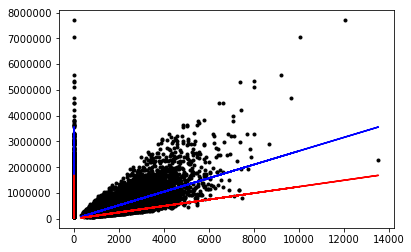

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(simple_feature_matrix,output,'k.',
         simple_feature_matrix,predict_output(simple_feature_matrix, simple_weights_0_penalty),'b-',
        simple_feature_matrix,predict_output(simple_feature_matrix, simple_weights_high_penalty),'r-')

### RSS on the TEST data - The initial weights (all zeros)

In [15]:
initial_weights = np.array([0.0,0.0])
test_predictions_initial_weights = predict_output(simple_test_feature_matrix, initial_weights) 
errors = test_predictions_initial_weights - test_output # prediction errors

print "Initial weights:", initial_weights
print "RSS = {:.3e}".format((errors**2).sum())

Initial weights: [ 0.  0.]
RSS = 1.784e+15


### RSS on the TEST data - The weights learned with no regularization

In [16]:
test_predictions_0_penalty = predict_output(simple_test_feature_matrix, simple_weights_0_penalty) 
errors = test_predictions_0_penalty - test_output # prediction errors

print "Weights learned with no regularization:", simple_weights_0_penalty
print 'RSS = {:.3e}'.format( (errors**2).sum())

Weights learned with no regularization: [ -1.63113501e-01   2.63024369e+02]
RSS = 2.757e+14


### RSS on the TEST data - The weights learned with high regularization

In [17]:
test_predictions_high_penalty = predict_output(simple_test_feature_matrix, simple_weights_high_penalty) 
errors = test_predictions_high_penalty - test_output # prediction errors

print "Weights learned with high regularization:", simple_weights_high_penalty 
print 'RSS = {:.3e}'.format((errors**2).sum())

Weights learned with high regularization: [  4.87184758e-02   1.24574021e+02]
RSS = 6.947e+14


# Running a multiple regression with L2 penalty

Let us consider a model with 2 features: `['sqft_living', 'sqft_living15']`.

First, create Numpy versions of training and test data with these two features. 

In [18]:
model_features = ['sqft_living', 'sqft_living15'] # sqft_living15 is the average squarefeet for the nearest 15 neighbors. 
my_output = 'price'
(feature_matrix, output) = get_numpy_data(train_data, model_features, my_output)
(test_feature_matrix, test_output) = get_numpy_data(test_data, model_features, my_output)

We need to re-inialize the weights, since we have one extra parameter. Set the step size and maximum number of iterations.

In [19]:
initial_weights = np.array([0.0,0.0,0.0])
step_size = 1e-12
max_iterations = 1000

First, let's consider no regularization.  Set the `l2_penalty` to `0.0` and run ridge regression algorithm to learn the weights of model.  

In [20]:
multiple_weights_0_penalty = ridge_regression_gradient_descent(feature_matrix, output, 
                                                             initial_weights, step_size, 
                                                             0.0, max_iterations)

Starting gradient descent with l2_penalty = 0.0
Iteration = 1
Cost function =  7.43305185103e+15
Iteration = 2
Cost function =  4.0567523315e+15
Iteration = 3
Cost function =  2.52956511433e+15
Iteration = 4
Cost function =  1.83855669428e+15
Iteration = 5
Cost function =  1.52567557521e+15
Iteration = 6
Cost function =  1.38378949867e+15
Iteration = 7
Cost function =  1.31923260628e+15
Iteration = 8
Cost function =  1.28964887203e+15
Iteration = 9
Cost function =  1.27588472408e+15
Iteration = 10
Cost function =  1.26927880758e+15
Iteration = 20
Cost function =  1.25781238632e+15
Iteration = 30
Cost function =  1.25195457127e+15
Iteration = 40
Cost function =  1.24675542316e+15
Iteration = 50
Cost function =  1.24213950875e+15
Iteration = 60
Cost function =  1.23804140114e+15
Iteration = 70
Cost function =  1.23440301346e+15
Iteration = 80
Cost function =  1.23117277498e+15
Iteration = 90
Cost function =  1.22830490006e+15
Iteration = 100
Cost function =  1.22575873926e+15
Iteration =

Next, consider high regularization.  Set the `l2_penalty` to `1e11` and run the ridge regression algorithm to learn the weights of model. 

In [21]:
multiple_weights_high_penalty = ridge_regression_gradient_descent(feature_matrix, output, 
                                                             initial_weights, step_size, 
                                                             1e11, max_iterations)

Starting gradient descent with l2_penalty = 1e+11
Iteration = 1
Cost function =  7.43305185103e+15
Iteration = 2
Cost function =  4.46048979029e+15
Iteration = 3
Cost function =  3.79667450411e+15
Iteration = 4
Cost function =  3.64831960165e+15
Iteration = 5
Cost function =  3.61509121313e+15
Iteration = 6
Cost function =  3.6076028942e+15
Iteration = 7
Cost function =  3.60588651766e+15
Iteration = 8
Cost function =  3.60547511492e+15
Iteration = 9
Cost function =  3.60536545352e+15
Iteration = 10
Cost function =  3.60532973348e+15
Iteration = 20
Cost function =  3.60529506612e+15
Iteration = 30
Cost function =  3.60529477424e+15
Iteration = 40
Cost function =  3.60529477136e+15
Iteration = 50
Cost function =  3.60529477134e+15
Iteration = 60
Cost function =  3.60529477134e+15
Iteration = 70
Cost function =  3.60529477134e+15
Iteration = 80
Cost function =  3.60529477134e+15
Iteration = 90
Cost function =  3.60529477134e+15
Iteration = 100
Cost function =  3.60529477134e+15
Iteration

### RSS on the test data - initial weights

In [22]:
initial_weights = np.array([0.0,0.0,0.0])
test_predictions_initial_weights = predict_output(test_feature_matrix, initial_weights) 
errors = test_predictions_initial_weights - test_output # prediction errors

print "Initial weights:", initial_weights
print "RSS = {:.3e}".format( (errors**2).sum())

Initial weights: [ 0.  0.  0.]
RSS = 1.784e+15


### Rss on test data - no regularization

In [23]:
test_predictions_0_penalty = predict_output(test_feature_matrix, multiple_weights_0_penalty) 
errors = test_predictions_0_penalty - test_output # prediction errors
print "Weights learned with no regularization:", multiple_weights_0_penalty
print "RSS = {:.3e}".format((errors**2).sum())

Weights learned with no regularization: [  -0.35743482  243.0541689    22.41481594]
RSS = 2.741e+14


### Rss on test data - high regularization`

In [24]:
test_predictions_high_penalty = predict_output(test_feature_matrix, multiple_weights_high_penalty) 
errors = test_predictions_high_penalty - test_output # prediction errors
print "Weights learned with high regularization:", multiple_weights_high_penalty
print "RSS = {:.3e}".format((errors**2).sum())

Weights learned with high regularization: [  3.36011656e-02   9.14901675e+01   7.84374904e+01]
RSS = 5.004e+14
